In [1]:
import numpy as np
import sys
sys.path.insert(1,'C:/Users/UASAL-OPTICS/Desktop/poke/') # One day I'll actually package poke!
import poke.poke_core as pol
from astropy.io import fits
import astropy.units as u
import poppy as poppy
# Try load and plot
elt_pupil = fits.open('ELT_Pupil_nospiders_256.fits')[0].data

In [2]:
# Load Refractive Indices
index_pth = "C:/Users/UASAL-OPTICS/Box/PolarizationGSMT/refractive_indices.csv"
data = np.genfromtxt(index_pth,delimiter=',',skip_header=2)[:,1:]
wlen_microns = data[:,0]
N_Ag = data[:,1] - 1j*data[:,2]
N_Al = data[:,3] - 1j*data[:,4]
N_SiN = data[:,5] - 1j*data[:,6]

# Film thickness for ELT
t_SiN = 55e-10 # 55 angstroms

# pick a band!
i = 3
n2 = [(N_SiN[i],t_SiN),(N_Ag[i])] 

In [3]:
# Load ELT pupils aoi
aoi_m1 = fits.open('ELT_aoi_surf0.fits')[0].data
aoi_m2 = fits.open('ELT_aoi_surf1.fits')[0].data
aoi_m3 = fits.open('ELT_aoi_surf2.fits')[0].data
aoi_m4 = fits.open('ELT_aoi_surf3.fits')[0].data
aoi_m5 = fits.open('ELT_aoi_surf4.fits')[0].data

In [4]:
def ComputeDiattenuationAndRetardance(aoi,film,wl):

    rs,rp = pol.FresnelCoefficients(aoi,1,film,wavelength=wl)

    D = (np.abs(rs)**2 - np.abs(rp)**2) / (np.abs(rs)**2 + np.abs(rp)**2)
    R = np.angle(rs) - np.angle(rp)

    return D,R 

DM1,RM1 = ComputeDiattenuationAndRetardance(aoi_m1,n2,wlen_microns[i]*1e-6)
DM2,RM2 = ComputeDiattenuationAndRetardance(aoi_m2,n2,wlen_microns[i]*1e-6)
DM3,RM3 = ComputeDiattenuationAndRetardance(aoi_m3,n2,wlen_microns[i]*1e-6)
DM4,RM4 = ComputeDiattenuationAndRetardance(aoi_m4,n2,wlen_microns[i]*1e-6)
DM5,RM5 = ComputeDiattenuationAndRetardance(aoi_m5,n2,wlen_microns[i]*1e-6)


C:\Users\UASAL-OPTICS\AppData\Local\Temp\ipykernel_16424\426408590.py:17: RuntimeWarning: invalid value encountered in true_divide
  im = ax[i,0].imshow(D[i]*elt_pupil/elt_pupil,interpolation='nearest')
C:\Users\UASAL-OPTICS\AppData\Local\Temp\ipykernel_16424\426408590.py:24: RuntimeWarning: invalid value encountered in true_divide
  im = ax[i,1].imshow(R[i]*elt_pupil/elt_pupil,interpolation='nearest')


NameError: name 'ComputePolAbCoeffs' is not defined

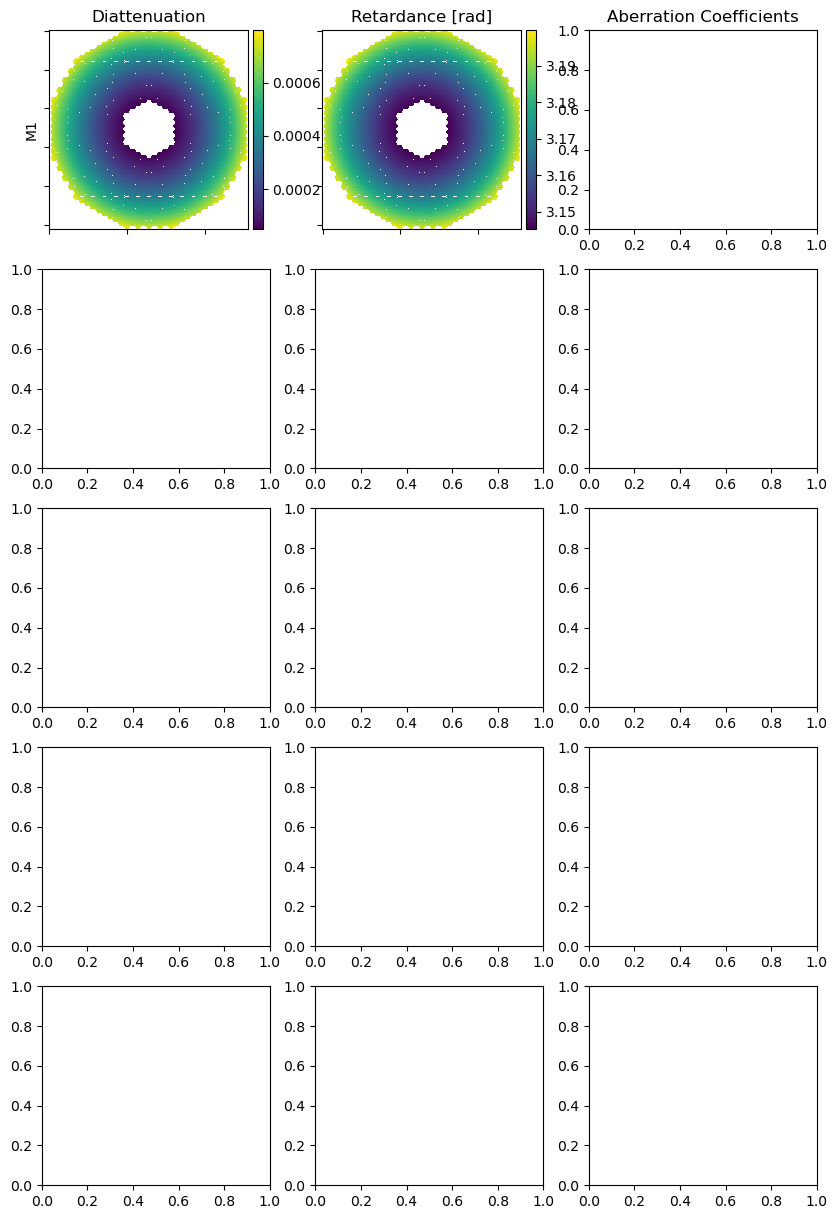

In [5]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

dx = np.arange(1,4,1)
rx = np.arange(1,4,1) + 0.5

D = [DM1,DM2,DM3,DM4,DM5]
# D.append(np.sum(D))
R = [RM1,RM2,RM3,RM4,RM5]

fig,ax = plt.subplots(ncols=3,nrows=5,figsize=[10,15])
ax[0,0].set_title('Diattenuation')
ax[0,1].set_title('Retardance [rad]')
ax[0,2].set_title('Aberration Coefficients')
for i in range(5):

    im = ax[i,0].imshow(D[i]*elt_pupil/elt_pupil,interpolation='nearest')
    divider = make_axes_locatable(ax[i,0])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im,cax=cax)
    ax[i,0].tick_params(labelbottom=False,labelleft=False)
    ax[i,0].set_ylabel('M{}'.format(i+1))

    im = ax[i,1].imshow(R[i]*elt_pupil/elt_pupil,interpolation='nearest')
    divider = make_axes_locatable(ax[i,1])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im,cax=cax)
    ax[i,1].tick_params(labelbottom=False,labelleft=False)

    ax[i,2].bar(dx,ComputePolAbCoeffs(D[i]),label='Diattenuation',width=0.5)
    ax[i,2].set_ylim([-1e-3,1e-3])
    ax[i,2].set_xticks(dx + 0.25)
    ax[i,2].set_xticklabels(['Tip','Tilt','Focus'])
    ax[i,2].set_ylabel('D')
    ax[i,2].set_xlim([1,4])

    axtwin = ax[i,2].twinx()
    axtwin.bar(rx,ComputePolAbCoeffs(R[i]),label='Retardance',color='orange',width=0.5)
    axtwin.plot(np.linspace(0,4,len(dx)),np.zeros(dx.shape),linestyle='dashed',color='black')
    axtwin.set_ylim([-np.pi/100,np.pi/100])
    axtwin.set_ylabel('R')

# fig.legend()
fig.tight_layout()
plt.show()

In [6]:
# Try out poppy zernike decomposition
def ComputePolAbCoeffs(map):

    dim = map.shape[0]

    x = np.linspace(-1,1,dim)
    x,y = np.meshgrid(x,x)

    # Piston
    Z0 = np.zeros(x.shape)#[x**2 + y**2 <=1]
    Z0[x**2 + y**2 <=1] = 1

    # Tip 
    Z1 = 2*x*Z0#[x**2 + y**2 <=1]

    # Tilt
    Z2 = 2*y*Z0#[x**2 + y**2 <=1]

    # Focus
    Z3 = np.sqrt(3)*(2*(x**2 + y**2)-1)*Z0#[x**2 + y**2 <=1]

    # Coefficient
    z0 = np.mean(Z0*map)
    z1 = np.mean(Z1*map)
    z2 = np.mean(Z2*map)
    z3 = np.mean(Z3*map)

    # plt.figure()
    # plt.title('Residuals')
    # plt.imshow((map - z0*Z0 - z1*Z1 - z2*Z2 - z3*Z3)/Z0)
    # plt.colorbar()
    # plt.show()

    return z1,z2,z3

ComputePolAbCoeffs(DM5)

(-1.3536645288307787e-19, 0.0001506996827968492, -1.5202864394574115e-06)

In [7]:
# Compute max, min, mean diattenuation
Dmax = []
Dmin = []
Dmean = []
Rmax = []
Rmin = []
Rmean = []
D_ELT = []
R_ELT = []

for i,wlen in enumerate(wlen_microns):

    n2 = [(N_SiN[i],t_SiN),(N_Ag[i])] 

    DM1,RM1 = ComputeDiattenuationAndRetardance(aoi_m1,n2,wlen*1e-6)
    DM2,RM2 = ComputeDiattenuationAndRetardance(aoi_m2,n2,wlen*1e-6)
    DM3,RM3 = ComputeDiattenuationAndRetardance(aoi_m3,n2,wlen*1e-6)
    DM4,RM4 = ComputeDiattenuationAndRetardance(aoi_m4,n2,wlen*1e-6)
    DM5,RM5 = ComputeDiattenuationAndRetardance(aoi_m5,n2,wlen*1e-6)

    # Sum diattenuation
    D = DM1 + DM2 + DM3 + DM4 + DM5
    D_ELT.append(D)
    Dmax.append(np.max(D))
    Dmin.append(np.min(D))
    Dmean.append(np.mean(D))

    # Sum retardance
    R = RM1 + RM2 + RM3 + RM4 + RM5
    R = R%(np.pi)
    R_ELT.append(R)
    Rmax.append(np.max(R))
    Rmin.append(np.min(R))
    Rmean.append(np.mean(R))

NameError: name 'Dmax_TMT' is not defined

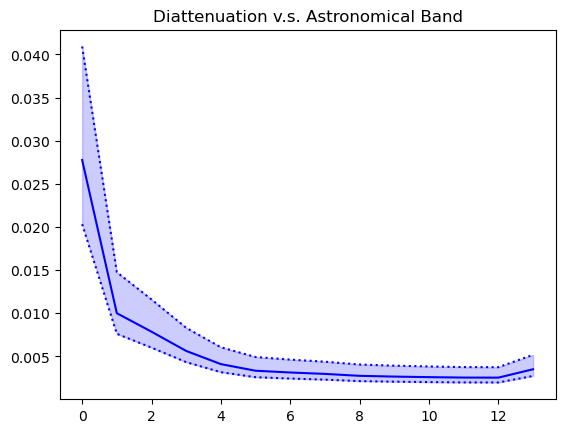

In [8]:
# set up a figure
bands = ['U','B' ,'g','V','R','I','z','y','J','H','K','L','M','N']
bandx = np.arange(0,len(bands),1)

plt.figure()
plt.title('Diattenuation v.s. Astronomical Band')
plt.plot(bandx,Dmax,color='blue',linestyle='dotted')
plt.plot(bandx,Dmin,color='blue',linestyle='dotted')
plt.plot(bandx,Dmean,color='blue',label='ELT')
plt.fill_between(bandx,Dmax,Dmin,alpha=0.2,color='blue')

plt.plot(bandx,Dmax_TMT,color='orange',linestyle='dotted')
plt.plot(bandx,Dmin_TMT,color='orange',linestyle='dotted')
plt.plot(bandx,Dmean_TMT,color='orange',label='TMT')
plt.fill_between(bandx,Dmax_TMT,Dmin_TMT,alpha=0.2,color='orange')

plt.legend()
plt.xticks(ticks=bandx,labels=bands)
plt.xlabel('Astronomical Band')
plt.ylabel('Diattenuation')
plt.ylim([0,.05])
plt.show()


NameError: name 'Rmax_GMT' is not defined

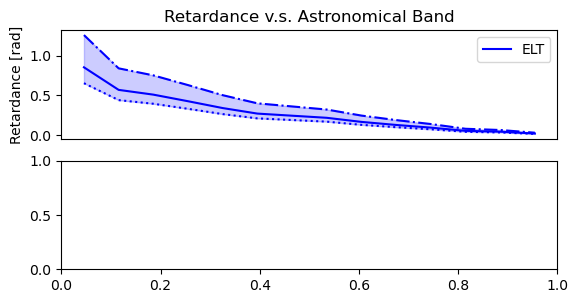

In [9]:
# set up a figure
bands = ['U','B' ,'g','V','R','I','z','y','J','H','K','L','M','N']
bandx = np.arange(0,len(bands),1)

plt.figure()
plt.subplot(311)
plt.title('Retardance v.s. Astronomical Band')
plt.plot(bandx,Rmax,color='blue',linestyle='dashdot')
plt.plot(bandx,Rmin,color='blue',linestyle='dotted')
plt.plot(bandx,Rmean,color='blue',label='ELT')
plt.legend()
# plt.xlabel('Astronomical Band')
plt.ylabel('Retardance [rad]')
plt.fill_between(bandx,Rmax,Rmin,alpha=0.2,color='blue')
plt.xticks([])
plt.subplot(312)
plt.plot(bandx,Rmax_GMT,color='green',linestyle='dashdot')
plt.plot(bandx,Rmin_GMT,color='green',linestyle='dotted')
plt.plot(bandx,Rmean_GMT,color='green',label='GMT')
plt.legend()
# plt.xlabel('Astronomical Band')
plt.ylabel('Retardance [rad]')
plt.fill_between(bandx,Rmax_GMT,Rmin_GMT,alpha=0.2,color='green')
plt.xticks([])
plt.subplot(313)
plt.plot(bandx,Rmax_TMT,color='orange',linestyle='dashdot')
plt.plot(bandx,Rmin_TMT,color='orange',linestyle='dotted')
plt.plot(bandx,Rmean_TMT,color='orange',label='TMT')
plt.fill_between(bandx,Rmax_TMT,Rmin_TMT,alpha=0.2,color='orange')
plt.legend()
plt.xticks(ticks=bandx,labels=bands)
plt.xlabel('Astronomical Band')
plt.ylabel('Retardance [rad]')
plt.show()

In [13]:
# Total Diattenuation and Retardance Figure
pth_to_box = 'C:/Users/UASAL-OPTICS/Box/PolarizationGSMT/'
pth_to_tmt = pth_to_box+'TMT/Incident_angles_reflection_old/ref_coeff_TMT_fil_' # need to add band
# pth_to_gmt = pth_to_box+'GMT/Incident_angles_reflection/ref_coeff_GMT_fil_' # need to add band, ramya needs to add these

pth = pth_to_tmt+'V.csv'
# load the data
# importing pandas
import pandas as pd
  
# read text file into pandas DataFrame
df = pd.read_csv(pth, sep=",")
  
# display DataFrame
print(df)

           0   -1   -1.1  0j 0j.1 0j.2 0j.3 0j.4 0j.5
0          1 -1.0 -0.992  0j   0j   0j   0j   0j   0j
1          2 -1.0 -0.984  0j   0j   0j   0j   0j   0j
2          3 -1.0 -0.976  0j   0j   0j   0j   0j   0j
3          4 -1.0 -0.969  0j   0j   0j   0j   0j   0j
4          5 -1.0 -0.961  0j   0j   0j   0j   0j   0j
...      ...  ...    ...  ..  ...  ...  ...  ...  ...
65530  65531  1.0  0.969  0j   0j   0j   0j   0j   0j
65531  65532  1.0  0.976  0j   0j   0j   0j   0j   0j
65532  65533  1.0  0.984  0j   0j   0j   0j   0j   0j
65533  65534  1.0  0.992  0j   0j   0j   0j   0j   0j
65534  65535  1.0  1.000  0j   0j   0j   0j   0j   0j

[65535 rows x 9 columns]


In [14]:
Px = []
Py = []
rsM1 = []
rpM1 = []
rsM2 = []
rpM2 = []
rsM3 = []
rpM3 = []
for i in range(65536):

    Px.append(df.loc[i]['Px'])
    Py.append(df.loc[i]['Py'])
    rsM1.append(df.loc[i]['rs_M1'])
    rpM1.append(df.loc[i]['rp_M1'])
    rsM2.append(df.loc[i]['rs_M2'])
    rpM2.append(df.loc[i]['rp_M2'])
    rsM3.append(df.loc[i]['rs_M3'])
    rpM3.append(df.loc[i]['rp_M3'])

KeyError: 'Px'

In [12]:
plt.scatter(Px,Py,c=rsM1[rsM1 != '0j'])
plt.colorbar()
plt.show()

IndexError: list index out of range

In [16]:
# Try run Ramya's code to grab the coefficients
file_dir = pth_to_box+'TMT/Incident_angles_reflection_old/'
b_fil=pd.read_csv(file_dir+'ref_coeff_TMT_fil_B.csv',header=None,names=['Px','Py','rp-M1','rs-M1','rp-M2','rs-M2','rp-M3','rs-M3'],
                  converters={'rp-M1': lambda s: complex(s.replace('i','j')),
                              'rs-M1': lambda s: complex(s.replace('i','j')),
                              'rp-M2': lambda s: complex(s.replace('i','j')),
                              'rs-M2': lambda s: complex(s.replace('i','j')),
                              'rp-M3': lambda s: complex(s.replace('i','j')),
                              'rs-M3': lambda s: complex(s.replace('i','j')),})

In [17]:
b_fil

,Px,Py,rp-M1,rs-M1,rp-M2,rs-M2,rp-M3,rs-M3
0,-1.0,-1.000,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j
1,-1.0,-0.992,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j
2,-1.0,-0.984,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j
3,-1.0,-0.976,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j
4,-1.0,-0.969,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j
...,...,...,...,...,...,...,...,...
65531,1.0,0.969,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j
65532,1.0,0.976,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j
65533,1.0,0.984,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j
65534,1.0,0.992,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j


In [18]:
Px = []
Py = []
rp_m1 = []
rs_m1 = []
rp_m2 = []
rs_m2 = []
rp_m3 = []
rs_m3 = []

for i in range(65536):

    # Save coords
    Px.append(b_fil.loc[:]['Px'][i])
    Py.append(b_fil.loc[:]['Py'][i])

    # HAVE TO SWITCH RS AND RP because Ramya saved them in reverse

    # Save m1
    rs_m1.append(b_fil.loc[:]['rp-M1'][i])
    rp_m1.append(b_fil.loc[:]['rs-M1'][i])

    # Save m2
    rs_m2.append(b_fil.loc[:]['rp-M2'][i])
    rp_m2.append(b_fil.loc[:]['rs-M2'][i])

    # Save m3
    rs_m3.append(b_fil.loc[:]['rp-M3'][i])
    rp_m3.append(b_fil.loc[:]['rs-M3'][i])

rp_m1 = np.reshape(rp_m1,[256,256])
# create a mask out of data
tmt_mask = np.copy(rp_m1)
tmt_mask[np.abs(rp_m1) <= 1e-6] = np.nan
tmt_mask[np.abs(rp_m1) >= 1e-6] = 1
tmt_mask = np.abs(tmt_mask)
rs_m1 = np.reshape(rs_m1,[256,256])

rp_m2 = np.reshape(rp_m2,[256,256])
rs_m2 = np.reshape(rs_m2,[256,256])

rp_m3 = np.reshape(rp_m3,[256,256])
rs_m3 = np.reshape(rs_m3,[256,256])

[]

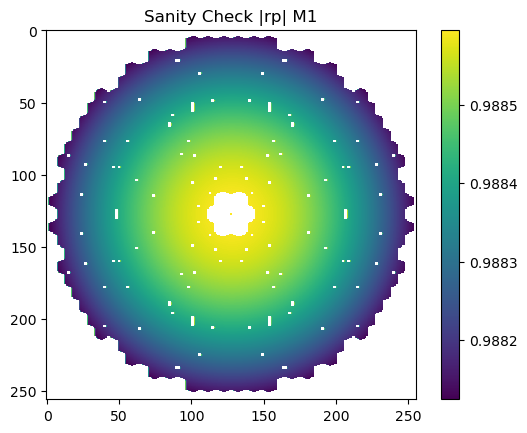

In [19]:
from astropy.io import fits
# tmt_pupil = fits.open('TMT_Pupil_256.fits')[0].data # This doesn't work
plt.figure()
plt.title('Sanity Check |rp| M1')
plt.imshow(np.abs(rp_m1)*tmt_mask/tmt_mask)
plt.colorbar()
plt.plot()

In [21]:
# Now make the min/max/mean plots
def ComputeDRFFromFresnel(array_s,array_p):

    # diattenuation
    D = (np.abs(array_s)**2 - np.abs(array_p)**2) / (np.abs(array_s)**2 + np.abs(array_p)**2)
    R = np.angle(array_s) - np.angle(array_p)

    return D,R

D_M1_TMT,R_M1_TMT = ComputeDRFFromFresnel(rs_m1,rp_m1)
D_M2_TMT,R_M2_TMT = ComputeDRFFromFresnel(rs_m2,rp_m2)
D_M3_TMT,R_M3_TMT = ComputeDRFFromFresnel(rs_m3,rp_m3)
D_TOT_TMT = D_M1_TMT + D_M2_TMT + D_M3_TMT
R_TOT_TMT = R_M1_TMT + R_M2_TMT + R_M3_TMT

C:\Users\UASAL-OPTICS\AppData\Local\Temp\ipykernel_16424\3573338990.py:5: RuntimeWarning: invalid value encountered in true_divide
  D = (np.abs(array_s)**2 - np.abs(array_p)**2) / (np.abs(array_s)**2 + np.abs(array_p)**2)


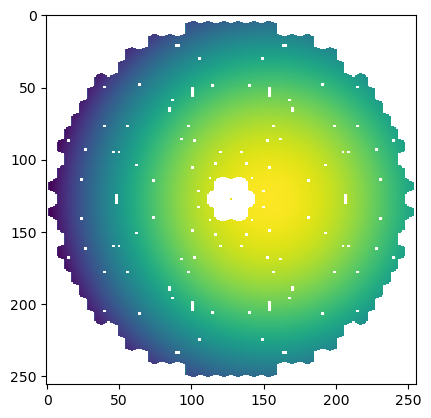

In [22]:
# Alrighty now the full data reduction gets done in a big loop
bands = ['U','B' ,'g','V','R','I','z','y','J','H','K','L','M','N']
D_TOT_TMT = []
R_TOT_TMT = []
for band in bands:
    # Try run Ramya's code to grab the coefficients
    file_dir = pth_to_box+'TMT/Reflection_coefficients/'
    # b_fil=pd.read_csv(file_dir+'ref_coeff_TMT_fil_{}.csv'.format(band),header=None,names=['Px','Py','rp-M1','rs-M1','rp-M2','rs-M2','rp-M3','rs-M3'],
    #                 converters={'rp-M1': lambda s: complex(s.replace('i','j')),
    #                             'rs-M1': lambda s: complex(s.replace('i','j')),
    #                             'rp-M2': lambda s: complex(s.replace('i','j')),
    #                             'rs-M2': lambda s: complex(s.replace('i','j')),
    #                             'rp-M3': lambda s: complex(s.replace('i','j')),
    #                             'rs-M3': lambda s: complex(s.replace('i','j')),})
    b_fil = pd.read_csv(file_dir+'ref_coeff_TMT_fil_{}.csv'.format(band),header=0,dtype='float')

    Px = []
    Py = []
    rp_m1 = []
    rs_m1 = []
    rp_m2 = []
    rs_m2 = []
    rp_m3 = []
    rs_m3 = []

    for i in range(65536):

        # Save coords
        Px.append(b_fil.loc[:]['Px'][i])
        Py.append(b_fil.loc[:]['Py'][i])

        # compute complex indices
        rpm1 = b_fil.loc[:]['rp-real-M1'][i] + 1j*b_fil.loc[:]['rp-imag-M1'][i]
        rsm1 = b_fil.loc[:]['rs-real-M1'][i] + 1j*b_fil.loc[:]['rs-imag-M1'][i]

        rpm2 = b_fil.loc[:]['rp-real-M2'][i] + 1j*b_fil.loc[:]['rp-imag-M2'][i]
        rsm2 = b_fil.loc[:]['rs-real-M2'][i] + 1j*b_fil.loc[:]['rs-imag-M2'][i]

        rpm3 = b_fil.loc[:]['rp-real-M3'][i] + 1j*b_fil.loc[:]['rp-imag-M3'][i]
        rsm3 = b_fil.loc[:]['rs-real-M3'][i] + 1j*b_fil.loc[:]['rs-imag-M3'][i]

        # Save m1
        rp_m1.append(rpm1)
        rs_m1.append(rsm1)

        # Save m2
        rp_m2.append(rpm2)
        rs_m2.append(rsm2)

        # Save m3
        rp_m3.append(rpm3)
        rs_m3.append(rsm3)

    rp_m1 = np.reshape(rp_m1,[256,256])
    # create a mask out of data
    tmt_mask = np.copy(rp_m1)
    tmt_mask[np.abs(rp_m1) <= 1e-6] = np.nan
    tmt_mask[np.abs(rp_m1) >= 1e-6] = 1
    tmt_mask = np.abs(tmt_mask)
    rs_m1 = np.reshape(rs_m1,[256,256])

    rp_m2 = np.reshape(rp_m2,[256,256])
    rs_m2 = np.reshape(rs_m2,[256,256])

    rp_m3 = np.reshape(rp_m3,[256,256])
    rs_m3 = np.reshape(rs_m3,[256,256])
    D_M1_TMT,R_M1_TMT = ComputeDRFFromFresnel(rs_m1,rp_m1)
    D_M2_TMT,R_M2_TMT = ComputeDRFFromFresnel(rs_m2,rp_m2)
    D_M3_TMT,R_M3_TMT = ComputeDRFFromFresnel(rs_m3,rp_m3)
    D_TOT_TMT.append(D_M1_TMT + D_M2_TMT + D_M3_TMT)
    R_TOT_TMT.append(R_M1_TMT + R_M2_TMT + R_M3_TMT)
    

C:\Users\UASAL-OPTICS\AppData\Local\Temp\ipykernel_16424\3573338990.py:5: RuntimeWarning: invalid value encountered in true_divide
  D = (np.abs(array_s)**2 - np.abs(array_p)**2) / (np.abs(array_s)**2 + np.abs(array_p)**2)
C:\Users\UASAL-OPTICS\AppData\Local\Temp\ipykernel_16424\3573338990.py:5: RuntimeWarning: invalid value encountered in true_divide
  D = (np.abs(array_s)**2 - np.abs(array_p)**2) / (np.abs(array_s)**2 + np.abs(array_p)**2)
C:\Users\UASAL-OPTICS\AppData\Local\Temp\ipykernel_16424\3573338990.py:5: RuntimeWarning: invalid value encountered in true_divide
  D = (np.abs(array_s)**2 - np.abs(array_p)**2) / (np.abs(array_s)**2 + np.abs(array_p)**2)
C:\Users\UASAL-OPTICS\AppData\Local\Temp\ipykernel_16424\3573338990.py:5: RuntimeWarning: invalid value encountered in true_divide
  D = (np.abs(array_s)**2 - np.abs(array_p)**2) / (np.abs(array_s)**2 + np.abs(array_p)**2)
C:\Users\UASAL-OPTICS\AppData\Local\Temp\ipykernel_16424\3573338990.py:5: RuntimeWarning: invalid value enco

In [23]:
b_fil = pd.read_csv(file_dir+'ref_coeff_TMT_fil_B.csv'.format(band),header=0)
b_fil

,Unnamed: 0,Px,Py,rp-real-M1,rp-imag-M1,rs-real-M1,rs-imag-M1,rp-real-M2,rp-imag-M2,rs-real-M2,rs-imag-M2,rp-real-M3,rp-imag-M3,rs-real-M3,rs-imag-M3
0,0,-1.0,-1.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,-1.0,-0.992,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,-1.0,-0.984,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,-1.0,-0.976,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,-1.0,-0.969,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65531,65531,1.0,0.969,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
65532,65532,1.0,0.976,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
65533,65533,1.0,0.984,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
65534,65534,1.0,0.992,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [24]:
Dmax_TMT = []
Dmin_TMT = []
Dmean_TMT = []

Rmax_TMT = []
Rmin_TMT = []
Rmean_TMT = []
for i,band in enumerate(bands):
    
    Dmax_TMT.append(np.nanmax(D_TOT_TMT[i]))
    Dmin_TMT.append(np.nanmin(D_TOT_TMT[i]))
    Dmean_TMT.append(np.nanmean(D_TOT_TMT[i]))

    Rmax_TMT.append(np.nanmax(R_TOT_TMT[i]/tmt_mask))
    Rmin_TMT.append(np.nanmin(R_TOT_TMT[i]/tmt_mask))
    Rmean_TMT.append(np.nanmean(R_TOT_TMT[i]/tmt_mask))

In [33]:
# Now the same for GMT
# Alrighty now the full data reduction gets done in a big loop
bands = ['U','B' ,'g','V','R','I','z','y','J','H','K','L','M','N']
D_TOT_GMT = []
R_TOT_GMT = []
for band in bands:
    # Try run Ramya's code to grab the coefficients
    file_dir = pth_to_box+'GMT/Reflection_coefficients/'
    # b_fil=pd.read_csv(file_dir+'ref_coeff_TMT_fil_{}.csv'.format(band),header=None,names=['Px','Py','rp-M1','rs-M1','rp-M2','rs-M2','rp-M3','rs-M3'],
    #                 converters={'rp-M1': lambda s: complex(s.replace('i','j')),
    #                             'rs-M1': lambda s: complex(s.replace('i','j')),
    #                             'rp-M2': lambda s: complex(s.replace('i','j')),
    #                             'rs-M2': lambda s: complex(s.replace('i','j')),
    #                             'rp-M3': lambda s: complex(s.replace('i','j')),
    #                             'rs-M3': lambda s: complex(s.replace('i','j')),})
    b_fil = pd.read_csv(file_dir+'ref_coeff_GMT_fil_{}.csv'.format(band),header=0,dtype='float')
    print(band,' loaded')
    Px = []
    Py = []
    rp_m1 = []
    rs_m1 = []
    rp_m2 = []
    rs_m2 = []
    rp_m3 = []
    rs_m3 = []

    for i in range(65536):

        # Save coords
        Px.append(b_fil.loc[:]['Px'][i])
        Py.append(b_fil.loc[:]['Py'][i])

        # compute complex indices
        rpm1 = b_fil.loc[:]['rp-real-M1'][i] + 1j*b_fil.loc[:]['rp-imag-M1'][i]
        rsm1 = b_fil.loc[:]['rs-real-M1'][i] + 1j*b_fil.loc[:]['rs-imag-M1'][i]

        rpm2 = b_fil.loc[:]['rp-real-M2'][i] + 1j*b_fil.loc[:]['rp-imag-M2'][i]
        rsm2 = b_fil.loc[:]['rs-real-M2'][i] + 1j*b_fil.loc[:]['rs-imag-M2'][i]

        rpm3 = b_fil.loc[:]['rp-real-M3'][i] + 1j*b_fil.loc[:]['rp-imag-M3'][i]
        rsm3 = b_fil.loc[:]['rs-real-M3'][i] + 1j*b_fil.loc[:]['rs-imag-M3'][i]

        # Save m1
        rp_m1.append(rpm1)
        rs_m1.append(rsm1)

        # Save m2
        rp_m2.append(rpm2)
        rs_m2.append(rsm2)

        # Save m3
        rp_m3.append(rpm3)
        rs_m3.append(rsm3)

    rp_m1 = np.reshape(rp_m1,[256,256])
    # create a mask out of data
    gmt_mask = np.copy(rp_m1)
    gmt_mask[np.abs(rp_m1) <= 1e-6] = np.nan
    gmt_mask[np.abs(rp_m1) >= 1e-6] = 1
    gmt_mask = np.abs(gmt_mask)
    rs_m1 = np.reshape(rs_m1,[256,256])

    rp_m2 = np.reshape(rp_m2,[256,256])
    rs_m2 = np.reshape(rs_m2,[256,256])

    rp_m3 = np.reshape(rp_m3,[256,256])
    rs_m3 = np.reshape(rs_m3,[256,256])
    D_M1_GMT,R_M1_GMT = ComputeDRFFromFresnel(rs_m1,rp_m1)
    D_M2_GMT,R_M2_GMT = ComputeDRFFromFresnel(rs_m2,rp_m2)
    D_M3_GMT,R_M3_GMT = ComputeDRFFromFresnel(rs_m3,rp_m3)
    D_TOT_GMT.append(D_M1_GMT + D_M2_GMT + D_M3_GMT)
    R_TOT_GMT.append(R_M1_GMT + R_M2_GMT + R_M3_GMT)
    

U  loaded


C:\Users\UASAL-OPTICS\AppData\Local\Temp\ipykernel_16424\3573338990.py:5: RuntimeWarning: invalid value encountered in true_divide
  D = (np.abs(array_s)**2 - np.abs(array_p)**2) / (np.abs(array_s)**2 + np.abs(array_p)**2)


B  loaded


C:\Users\UASAL-OPTICS\AppData\Local\Temp\ipykernel_16424\3573338990.py:5: RuntimeWarning: invalid value encountered in true_divide
  D = (np.abs(array_s)**2 - np.abs(array_p)**2) / (np.abs(array_s)**2 + np.abs(array_p)**2)


g  loaded


C:\Users\UASAL-OPTICS\AppData\Local\Temp\ipykernel_16424\3573338990.py:5: RuntimeWarning: invalid value encountered in true_divide
  D = (np.abs(array_s)**2 - np.abs(array_p)**2) / (np.abs(array_s)**2 + np.abs(array_p)**2)


V  loaded


C:\Users\UASAL-OPTICS\AppData\Local\Temp\ipykernel_16424\3573338990.py:5: RuntimeWarning: invalid value encountered in true_divide
  D = (np.abs(array_s)**2 - np.abs(array_p)**2) / (np.abs(array_s)**2 + np.abs(array_p)**2)


R  loaded


C:\Users\UASAL-OPTICS\AppData\Local\Temp\ipykernel_16424\3573338990.py:5: RuntimeWarning: invalid value encountered in true_divide
  D = (np.abs(array_s)**2 - np.abs(array_p)**2) / (np.abs(array_s)**2 + np.abs(array_p)**2)


I  loaded


C:\Users\UASAL-OPTICS\AppData\Local\Temp\ipykernel_16424\3573338990.py:5: RuntimeWarning: invalid value encountered in true_divide
  D = (np.abs(array_s)**2 - np.abs(array_p)**2) / (np.abs(array_s)**2 + np.abs(array_p)**2)


z  loaded


C:\Users\UASAL-OPTICS\AppData\Local\Temp\ipykernel_16424\3573338990.py:5: RuntimeWarning: invalid value encountered in true_divide
  D = (np.abs(array_s)**2 - np.abs(array_p)**2) / (np.abs(array_s)**2 + np.abs(array_p)**2)


y  loaded


C:\Users\UASAL-OPTICS\AppData\Local\Temp\ipykernel_16424\3573338990.py:5: RuntimeWarning: invalid value encountered in true_divide
  D = (np.abs(array_s)**2 - np.abs(array_p)**2) / (np.abs(array_s)**2 + np.abs(array_p)**2)


J  loaded


C:\Users\UASAL-OPTICS\AppData\Local\Temp\ipykernel_16424\3573338990.py:5: RuntimeWarning: invalid value encountered in true_divide
  D = (np.abs(array_s)**2 - np.abs(array_p)**2) / (np.abs(array_s)**2 + np.abs(array_p)**2)


H  loaded


C:\Users\UASAL-OPTICS\AppData\Local\Temp\ipykernel_16424\3573338990.py:5: RuntimeWarning: invalid value encountered in true_divide
  D = (np.abs(array_s)**2 - np.abs(array_p)**2) / (np.abs(array_s)**2 + np.abs(array_p)**2)


K  loaded


C:\Users\UASAL-OPTICS\AppData\Local\Temp\ipykernel_16424\3573338990.py:5: RuntimeWarning: invalid value encountered in true_divide
  D = (np.abs(array_s)**2 - np.abs(array_p)**2) / (np.abs(array_s)**2 + np.abs(array_p)**2)


L  loaded


C:\Users\UASAL-OPTICS\AppData\Local\Temp\ipykernel_16424\3573338990.py:5: RuntimeWarning: invalid value encountered in true_divide
  D = (np.abs(array_s)**2 - np.abs(array_p)**2) / (np.abs(array_s)**2 + np.abs(array_p)**2)


M  loaded


C:\Users\UASAL-OPTICS\AppData\Local\Temp\ipykernel_16424\3573338990.py:5: RuntimeWarning: invalid value encountered in true_divide
  D = (np.abs(array_s)**2 - np.abs(array_p)**2) / (np.abs(array_s)**2 + np.abs(array_p)**2)


N  loaded


C:\Users\UASAL-OPTICS\AppData\Local\Temp\ipykernel_16424\3573338990.py:5: RuntimeWarning: invalid value encountered in true_divide
  D = (np.abs(array_s)**2 - np.abs(array_p)**2) / (np.abs(array_s)**2 + np.abs(array_p)**2)


In [34]:
Dmax_GMT = []
Dmin_GMT = []
Dmean_GMT = []

Rmax_GMT = []
Rmin_GMT = []
Rmean_GMT = []
for i,band in enumerate(bands):
    
    Dmax_GMT.append(np.nanmax(D_TOT_GMT[i]))
    Dmin_GMT.append(np.nanmin(D_TOT_GMT[i]))
    Dmean_GMT.append(np.nanmean(D_TOT_GMT[i]))

    Rmax_GMT.append(np.nanmax(R_TOT_GMT[i]/gmt_mask))
    Rmin_GMT.append(np.nanmin(R_TOT_GMT[i]/gmt_mask))
    Rmean_GMT.append(np.nanmean(R_TOT_GMT[i]/gmt_mask))

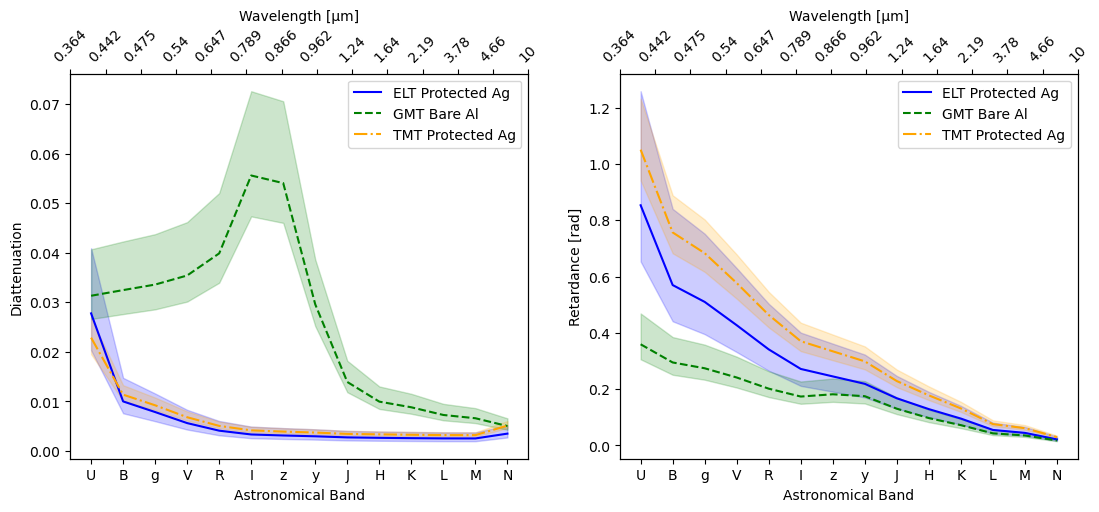

In [59]:
wlen = [0.364,0.442,0.475,0.540,0.647,0.789,0.866,0.962,1.24,1.64,2.19,3.78,4.66,10]

plt.figure(figsize=[13,5])
plt.subplot(122)
# plt.plot(bandx,Rmax,color='blue',linestyle='dashdot')
# plt.plot(bandx,Rmin,color='blue',linestyle='dotted')
plt.plot(bandx,Rmean,color='blue',label='ELT Protected Ag',linestyle='solid')
plt.fill_between(bandx,Rmax,Rmin,alpha=0.2,color='blue')
# plt.plot(bandx,Rmax_GMT,color='green',linestyle='dashdot')
# plt.plot(bandx,Rmin_GMT,color='green',linestyle='dotted')
plt.plot(bandx,Rmean_GMT,color='green',label='GMT Bare Al',linestyle='dashed')
plt.fill_between(bandx,Rmax_GMT,Rmin_GMT,alpha=0.2,color='green')
# plt.plot(bandx,Rmax_TMT,color='orange',linestyle='dashdot')
# plt.plot(bandx,Rmin_TMT,color='orange',linestyle='dotted')
plt.plot(bandx,Rmean_TMT,color='orange',label='TMT Protected Ag',linestyle='dashdot')
plt.fill_between(bandx,Rmax_TMT,Rmin_TMT,alpha=0.2,color='orange')
plt.legend()
plt.xticks(ticks=bandx,labels=bands)
plt.xlabel('Astronomical Band')
plt.ylabel('Retardance [rad]')
ax1 = plt.twiny()
ax1.set_xlim([bandx[0],bandx[-1]])
ax1.set_xticks(bandx)
ax1.set_xticklabels(wlen,rotation=45)
ax1.set_xlabel('Wavelength [µm]')

plt.subplot(121)
# plt.plot(bandx,Dmax,color='blue',linestyle='dashdot')
# plt.plot(bandx,Dmin,color='blue',linestyle='dotted')
plt.plot(bandx,Dmean,color='blue',label='ELT Protected Ag')
plt.fill_between(bandx,Dmax,Dmin,alpha=0.2,color='blue')
# plt.plot(bandx,Dmax_GMT,color='green',linestyle='dashdot')
# plt.plot(bandx,Dmin_GMT,color='green',linestyle='dotted')
plt.plot(bandx,Dmean_GMT,color='green',label='GMT Bare Al',linestyle='dashed')
plt.fill_between(bandx,Dmax_GMT,Dmin_GMT,alpha=0.2,color='green')
# plt.plot(bandx,Dmax_TMT,color='orange',linestyle='dashdot')
# plt.plot(bandx,Dmin_TMT,color='orange',linestyle='dotted')
plt.plot(bandx,Dmean_TMT,color='orange',label='TMT Protected Ag',linestyle='dashdot')
plt.fill_between(bandx,Dmax_TMT,Dmin_TMT,alpha=0.2,color='orange')
plt.legend()
plt.xticks(ticks=bandx,labels=bands)
plt.xlabel('Astronomical Band')
plt.ylabel('Diattenuation')
ax2 = plt.twiny()
ax2.set_xlim([bandx[0],bandx[-1]])
ax2.set_xticks(bandx)
ax2.set_xticklabels(wlen,rotation=45)
ax2.set_xlabel('Wavelength [µm]')
plt.savefig('Diattenuation_And_Retardance_vs_band.pdf')
plt.show()

C:\Users\UASAL-OPTICS\AppData\Local\Temp\ipykernel_16424\2476013004.py:5: RuntimeWarning: invalid value encountered in true_divide
  im = ax[i,0].imshow(D_ELT[3]*elt_pupil/elt_pupil,interpolation='nearest')
C:\Users\UASAL-OPTICS\AppData\Local\Temp\ipykernel_16424\2476013004.py:13: RuntimeWarning: invalid value encountered in true_divide
  im = ax[i,1].imshow(R_ELT[3]*elt_pupil/elt_pupil,interpolation='nearest')


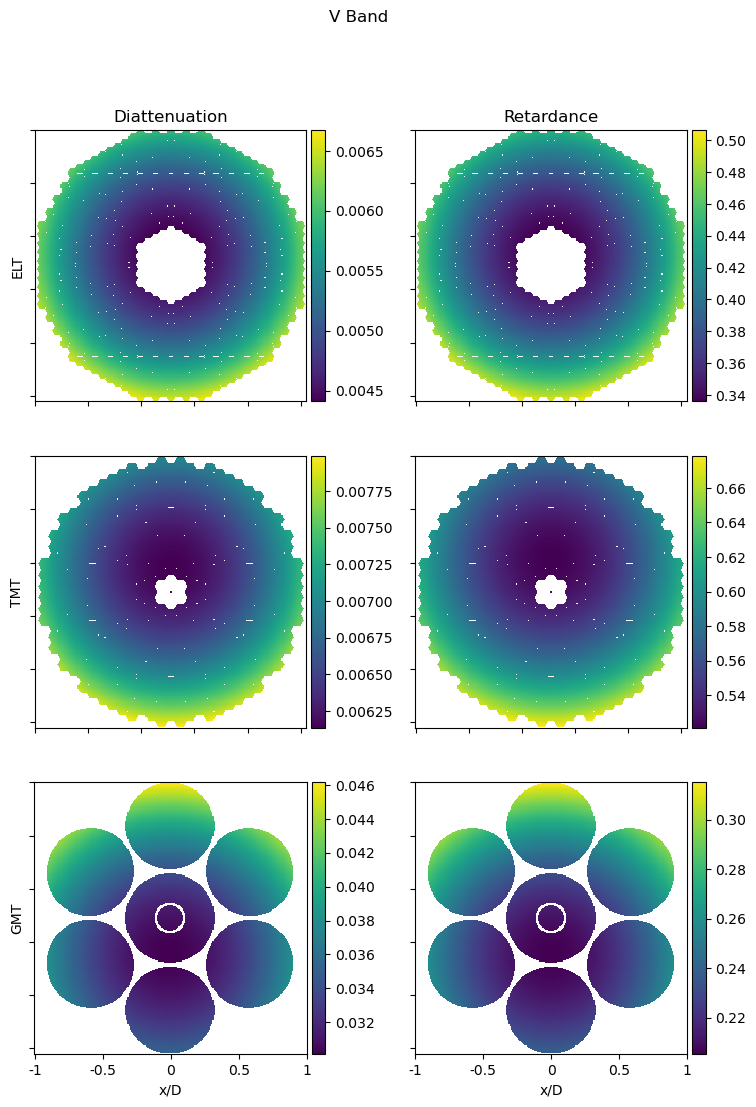

In [36]:

fig,ax = plt.subplots(ncols=2,nrows=3,figsize=[9,12])
plt.suptitle('V Band')
# ELT
i = 0
im = ax[i,0].imshow(D_ELT[3]*elt_pupil/elt_pupil,interpolation='nearest')
divider = make_axes_locatable(ax[i,0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im,cax=cax)
ax[i,0].tick_params(labelbottom=False,labelleft=False)
ax[i,0].set_ylabel('ELT')
ax[i,0].set_title('Diattenuation')

im = ax[i,1].imshow(R_ELT[3]*elt_pupil/elt_pupil,interpolation='nearest')
divider = make_axes_locatable(ax[i,1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im,cax=cax)
ax[i,1].tick_params(labelbottom=False,labelleft=False)
ax[i,1].set_title('Retardance')

# ax[i,2].bar(dx,ComputePolAbCoeffs(D),label='Diattenuation',width=0.5)
# ax[i,2].set_ylim([-1e-3,1e-3])
# ax[i,2].set_xticks(dx + 0.25)
# ax[i,2].set_xticklabels(['Tip','Tilt','Focus'])
# ax[i,2].set_ylabel('D')
# ax[i,2].set_xlim([1,4])

# axtwin = ax[i,2].twinx()
# axtwin.bar(rx,ComputePolAbCoeffs(R),label='Retardance',color='orange',width=0.5)
# axtwin.plot(np.linspace(0,4,len(dx)),np.zeros(dx.shape),linestyle='dashed',color='black')
# axtwin.set_ylim([-np.pi/100,np.pi/100])
# axtwin.set_ylabel('R')

# TMT
i = 1
im = ax[i,0].imshow(np.rot90(D_TOT_TMT[3]),interpolation='nearest')
divider = make_axes_locatable(ax[i,0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im,cax=cax)
ax[i,0].tick_params(labelbottom=False,labelleft=False)
ax[i,0].set_ylabel('TMT')

im = ax[i,1].imshow(np.rot90(R_TOT_TMT[3]*tmt_mask/tmt_mask),interpolation='nearest')
divider = make_axes_locatable(ax[i,1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im,cax=cax)
ax[i,1].tick_params(labelbottom=False,labelleft=False)

# ax[i,2].bar(dx,ComputePolAbCoeffs(D_TOT_TMT[3]),label='Diattenuation',width=0.5)
# ax[i,2].set_ylim([-1e-3,1e-3])
# ax[i,2].set_xticks(dx + 0.25)
# ax[i,2].set_xticklabels(['Tip','Tilt','Focus'])
# ax[i,2].set_ylabel('D')
# ax[i,2].set_xlim([1,4])

# axtwin = ax[i,2].twinx()
# axtwin.bar(rx,ComputePolAbCoeffs(R_TOT_TMT[3]),label='Retardance',color='orange',width=0.5)
# axtwin.plot(np.linspace(0,4,len(dx)),np.zeros(dx.shape),linestyle='dashed',color='black')
# axtwin.set_ylim([-np.pi/100,np.pi/100])
# axtwin.set_ylabel('R')

# GMT
i = 2
im = ax[i,0].imshow(np.rot90(D_TOT_GMT[3]),interpolation='nearest')
divider = make_axes_locatable(ax[i,0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im,cax=cax)
ax[i,0].tick_params(labelbottom=True,labelleft=False)
ax[i,0].set_ylabel('GMT')
ax[i,0].set_xlabel('x/D')
ax[i,0].set_xticks([0,64,128,192,256])
ax[i,0].set_xticklabels([-1,-0.5,0,0.5,1])

im = ax[i,1].imshow(np.rot90(R_TOT_GMT[3]*gmt_mask/gmt_mask),interpolation='nearest')
divider = make_axes_locatable(ax[i,1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im,cax=cax)
ax[i,1].tick_params(labelbottom=True,labelleft=False)
ax[i,1].set_xlabel('x/D')
ax[i,1].set_xticks([0,64,128,192,256])
ax[i,1].set_xticklabels([-1,-0.5,0,0.5,1])

# ax[i,2].bar(dx,ComputePolAbCoeffs(D_TOT_GMT[3]),label='Diattenuation',width=0.5)
# ax[i,2].set_ylim([-1e-3,1e-3])
# ax[i,2].set_xticks(dx + 0.25)
# ax[i,2].set_xticklabels(['Tip','Tilt','Focus'])
# ax[i,2].set_ylabel('D')
# ax[i,2].set_xlim([1,4])

# axtwin = ax[i,2].twinx()
# axtwin.bar(rx,ComputePolAbCoeffs(R_TOT_GMT[3]),label='Retardance',color='orange',width=0.5)
# axtwin.plot(np.linspace(0,4,len(dx)),np.zeros(dx.shape),linestyle='dashed',color='black')
# axtwin.set_ylim([-np.pi/100,np.pi/100])
# axtwin.set_ylabel('R')
fig.savefig('Vband_Total_Polarization_Aberration.png')
plt.show()

In [37]:
# Can we recreate the same data from the eigendecomposition of the Jones matrix?
def ComputeTotalPolByBand(pth_to_telescope):
    
    pth = pth_to_telescope
    J = np.empty([len(bands),256,256,2,2],dtype='complex128')
    for i,band in enumerate(bands):

        # load jones pupil
        Exx = fits.open(pth+'Exxr_{}.fits'.format(band))[0].data + 1j*fits.open(pth+'Exxi_{}.fits'.format(band))[0].data
        Exy = fits.open(pth+'Exyr_{}.fits'.format(band))[0].data + 1j*fits.open(pth+'Exyi_{}.fits'.format(band))[0].data
        Eyx = fits.open(pth+'Eyxr_{}.fits'.format(band))[0].data + 1j*fits.open(pth+'Eyxi_{}.fits'.format(band))[0].data
        Eyy = fits.open(pth+'Eyyr_{}.fits'.format(band))[0].data + 1j*fits.open(pth+'Eyyi_{}.fits'.format(band))[0].data

        # store in jones box
        J[i,...,0,0] = Exx
        J[i,...,0,1] = Exy
        J[i,...,1,0] = Eyx
        J[i,...,1,1] = Eyy

    print(J)

    val,vec = np.linalg.eig(J)
    dtest = (np.abs(val[...,0])**2 - np.abs(val[...,1])**2) / (np.abs(val[...,0])**2 + np.abs(val[...,1])**2)
    rtest = np.angle(val[...,0]) - np.angle(val[...,1]) 

    return dtest,rtest

In [38]:
# ELT computation
pth_to_elt = pth_to_box+'ELT/Jones_Pupils/'
dtest_elt,rtest_elt = ComputeTotalPolByBand(pth_to_elt)

D_max_elt = np.max(np.max(dtest_elt,axis=1),axis=1)
D_min_elt = np.min(np.min(dtest_elt,axis=1),axis=1)
D_mean_elt = np.mean(np.mean(dtest_elt,axis=1),axis=1)

R_max_elt = np.max(np.max(rtest_elt%np.pi,axis=1),axis=1)
R_min_elt = np.min(np.min(rtest_elt%np.pi,axis=1),axis=1)
R_mean_elt = np.mean(np.mean(rtest_elt%np.pi,axis=1),axis=1)

[[[[[-0.29694596+0.68270283j -0.18435579-0.07832686j]
    [ 0.18935375-0.05130078j -0.14283975-0.71628269j]]

   [[-0.29856178+0.68245334j -0.18309692-0.07778735j]
    [ 0.18804376-0.05100217j -0.14461744-0.71621502j]]

   [[-0.30016673+0.68220312j -0.18183385-0.07724604j]
    [ 0.18672976-0.05070133j -0.14638376-0.7161444j ]]

   ...

   [[-0.30016673+0.68220312j  0.18183385+0.07724604j]
    [-0.18672976+0.05070133j -0.14638376-0.7161444j ]]

   [[-0.29856178+0.68245334j  0.18309692+0.07778735j]
    [-0.18804376+0.05100217j -0.14461744-0.71621502j]]

   [[-0.29694596+0.68270283j  0.18435579+0.07832686j]
    [-0.18935375+0.05130078j -0.14283975-0.71628269j]]]


  [[[-0.29558329+0.68365344j -0.18297261-0.07776581j]
    [ 0.18791966-0.05099652j -0.14155869-0.7169836j ]]

   [[-0.29719789+0.68340211j -0.18172329-0.07723031j]
    [ 0.18661964-0.05069991j -0.14333615-0.71691379j]]

   [[-0.29880163+0.68315005j -0.18046981-0.07669303j]
    [ 0.18531565-0.05040106j -0.14510224-0.71684104j]]



In [ ]:
# TMT computation
pth_to_tmt = pth_to_box+'TMT/Jones_pupils_fits_files/'
dtest_tmt,rtest_tmt = ComputeTotalPolByBand(pth_to_tmt)

D_max_tmt = np.max(np.max(dtest_tmt,axis=1),axis=1)
D_min_tmt = np.min(np.min(dtest_tmt,axis=1),axis=1)
D_mean_tmt = np.mean(np.mean(dtest_tmt,axis=1),axis=1)

R_max_tmt = np.max(np.max(rtest_tmt,axis=1),axis=1)
R_min_tmt = np.min(np.min(rtest_tmt,axis=1),axis=1)
R_mean_tmt = np.mean(np.mean(rtest_tmt,axis=1),axis=1)

[]
[]


LinAlgError: Array must not contain infs or NaNs

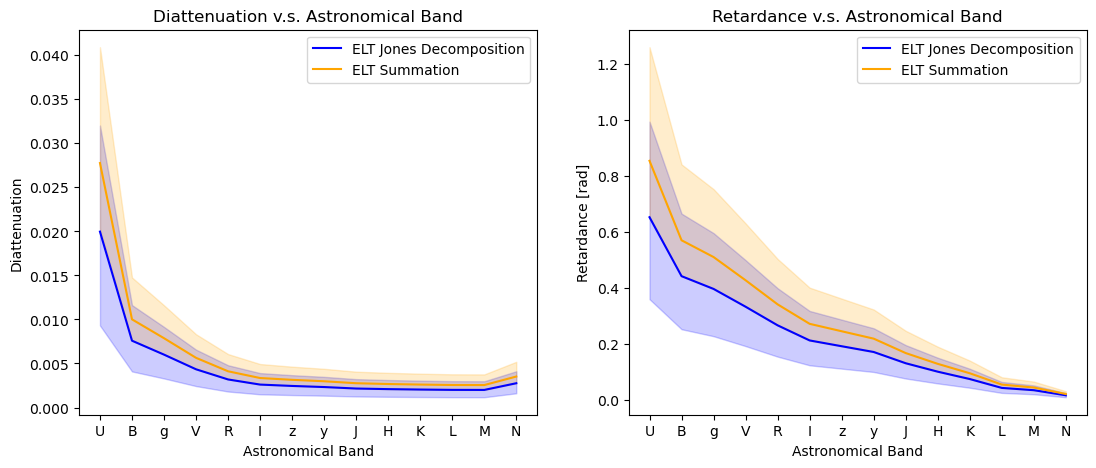

In [39]:
plt.figure(figsize=[13,5])
plt.subplot(122)
plt.title('Retardance v.s. Astronomical Band')
plt.plot(bandx,R_mean_elt,color='blue',label='ELT Jones Decomposition')
plt.fill_between(bandx,R_max_elt,R_min_elt,alpha=0.2,color='blue')
plt.plot(bandx,Rmean,color='orange',label='ELT Summation')
plt.fill_between(bandx,Rmax,Rmin,alpha=0.2,color='orange')
# plt.plot(bandx,Rmean_GMT,color='green',label='GMT Bare Al')
# # plt.fill_between(bandx,Rmax_GMT,Rmin_GMT,alpha=0.2,color='green')
# plt.plot(bandx,R_mean_tmt,color='orange',label='TMT Protected Ag')
# plt.fill_between(bandx,R_max_tmt,R_min_tmt,alpha=0.2,color='orange')
plt.legend()
plt.xticks(ticks=bandx,labels=bands)
plt.xlabel('Astronomical Band')
plt.ylabel('Retardance [rad]')

plt.subplot(121)
plt.title('Diattenuation v.s. Astronomical Band')
plt.plot(bandx,D_mean_elt,color='blue',label='ELT Jones Decomposition')
plt.fill_between(bandx,D_max_elt,D_min_elt,alpha=0.2,color='blue')
plt.plot(bandx,Dmean,color='orange',label='ELT Summation')
plt.fill_between(bandx,Dmax,Dmin,alpha=0.2,color='orange')
# plt.plot(bandx,Dmean_GMT,color='green',label='GMT Bare Al Summation')
# plt.fill_between(bandx,Dmax_GMT,Dmin_GMT,alpha=0.2,color='green')
# plt.plot(bandx,Dmean_TMT,color='orange',label='TMT Protected Ag Summation')
# plt.fill_between(bandx,Dmax_TMT,Dmin_TMT,alpha=0.2,color='orange')
plt.legend()
plt.xticks(ticks=bandx,labels=bands)
plt.xlabel('Astronomical Band')
plt.ylabel('Diattenuation')
# plt.savefig('Diattenuation_And_Retardance_vs_band.png')
plt.show()

NameError: name 'R_mean_tmt' is not defined

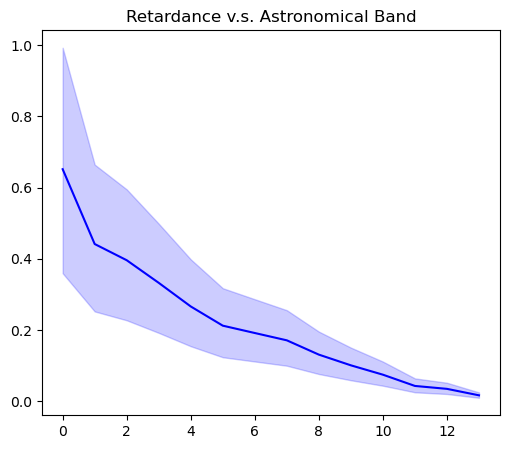

In [40]:
plt.figure(figsize=[13,5])
plt.subplot(122)
plt.title('Retardance v.s. Astronomical Band')
plt.plot(bandx,R_mean_elt,color='blue',label='ELT Protected Silver')
plt.fill_between(bandx,R_max_elt,R_min_elt,alpha=0.2,color='blue')
# plt.plot(bandx,Rmean_GMT,color='green',label='GMT Bare Al')
# plt.fill_between(bandx,Rmax_GMT,Rmin_GMT,alpha=0.2,color='green')
plt.plot(bandx,R_mean_tmt,color='orange',label='TMT Protected Ag')
plt.fill_between(bandx,R_max_tmt,R_min_tmt,alpha=0.2,color='orange')
plt.legend()
plt.xticks(ticks=bandx,labels=bands)
plt.xlabel('Astronomical Band')
plt.ylabel('Retardance [rad]')

plt.subplot(121)
plt.title('Diattenuation v.s. Astronomical Band')
plt.plot(bandx,D_mean_elt,color='blue',label='ELT Protected Silver')
plt.fill_between(bandx,D_max_elt,D_min_elt,alpha=0.2,color='blue')
# plt.plot(bandx,Dmean_GMT,color='green',label='GMT Bare Al Summation')
# plt.fill_between(bandx,Dmax_GMT,Dmin_GMT,alpha=0.2,color='green')
plt.plot(bandx,D_mean_tmt,color='orange',label='TMT Protected Ag')
plt.fill_between(bandx,D_max_tmt,D_min_tmt,alpha=0.2,color='orange')
plt.legend()
plt.xticks(ticks=bandx,labels=bands)
plt.xlabel('Astronomical Band')
plt.ylabel('Diattenuation')
plt.show()